In [1]:
#this notebook is for WK5 capstone project 

In [2]:
#import Libs 
import numpy as np  

import pandas as pd  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup  
import requests

!pip install pgeocode
import pgeocode

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.8-main

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.5.30          |   py38h578d9bd_0         141 KB  conda-forge
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.2.0                |     pyhd8ed1ab_0          67 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.52-pyhd8ed1ab_0
  geopy              conda-forge/noarch::geopy-2.2.0-pyhd8ed1ab_0
  pyth

In [3]:
#scrap the Toronto Postal Codes from Wiki website data 
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [4]:
#check header data 
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [5]:
#get latitude and the longitude coordinates of each neighborhood
pgeocode.Nominatim('ca')
geolocator = pgeocode.Nominatim('ca')
postal_codes = df['PostalCode'].tolist()
latitudes = []
longitudes = []
for i, postal_code in enumerate(postal_codes):
    # initialize your variable to None
    #print(f'--Getting Postal Code: {postal_code}')
    g = geolocator.query_postal_code(postal_code)
    
    if not g.empty:
        #print(f'Postal Code {postal_code} has been retrieved. {len(postal_codes) - (i + 1)} codes left')
        latitudes.append(g.latitude)
        longitudes.append(g.longitude)


df['latitudes'] = latitudes
df['longitudes'] = longitudes

#drop the blanks 
neighborhoods = df.dropna()
#check header data
neighborhoods.head(10)

,PostalCode,Borough,Neighborhood,latitudes,longitudes
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889
5,M9A,Etobicoke,Islington Avenue,43.6662,-79.5282
6,M1B,Scarborough,"Malvern, Rouge",43.8113,-79.1930
7,M3B,North York,Don Mills North,43.7450,-79.3590
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7063,-79.3094
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783


In [6]:
#setup Toronto Map
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighborhood in zip(neighborhoods['latitudes'], neighborhoods['longitudes'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [7]:
#Foursquare ID setup HIDDEN

CLIENT_ID = 'HIDDEN'  # your Foursquare ID
CLIENT_SECRET = 'HIDDEN' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


In [8]:
#setup function for finding Foursquare venue data 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
#call our Foursquare venue function for our Toronto Neighborhood data
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['latitudes'],
                                   longitudes=neighborhoods['longitudes']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [10]:
#display current sushi restaurants 
Sushi_Restaurants = toronto_venues.loc[toronto_venues['Venue Category'] == "Sushi Restaurant"]
Sushi_Restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
64,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504,Yuki Japanese Restaurant,43.720610,-79.456119,Sushi Restaurant
69,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504,Tora Aburi Sushi,43.724257,-79.455383,Sushi Restaurant
103,Ontario Provincial Government,43.6641,-79.3889,Tokyo Sushi,43.665885,-79.386977,Sushi Restaurant
114,Ontario Provincial Government,43.6641,-79.3889,Sushi Garden,43.664858,-79.384941,Sushi Restaurant
170,"Garden District, Ryerson",43.6572,-79.3783,Spring Sushi,43.656253,-79.380660,Sushi Restaurant
539,Leaside,43.7124,-79.3644,Kintako Japanese Restaurant,43.711597,-79.363962,Sushi Restaurant
561,Central Bay Street,43.6564,-79.3860,Japango,43.655268,-79.385165,Sushi Restaurant
597,Central Bay Street,43.6564,-79.3860,Spring Sushi,43.656253,-79.380660,Sushi Restaurant
708,"Richmond, Adelaide, King",43.6496,-79.3833,Tachi,43.650596,-79.383396,Sushi Restaurant
724,"Richmond, Adelaide, King",43.6496,-79.3833,JaBistro,43.649687,-79.388090,Sushi Restaurant


In [11]:
#map neighborhoods with sushi Restaurants 

#setup Toronto Map
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(Sushi_Restaurants ['Neighborhood Latitude'], Sushi_Restaurants ['Neighborhood Longitude'], Sushi_Restaurants ['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


In [12]:
#map sushi Restaurants 

#setup Toronto Map
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, Venue, neighborhood in zip(Sushi_Restaurants ['Venue Latitude'], Sushi_Restaurants ['Venue Longitude'], Sushi_Restaurants ['Venue'],Sushi_Restaurants ['Neighborhood']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

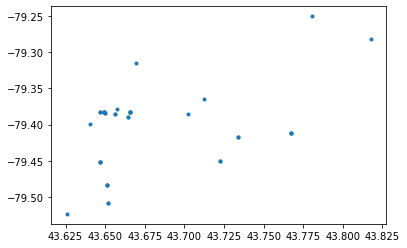

In [40]:
#convert the Sushi Restaurants locations into an array and plot data points 
City_center=[43.6534817, -79.3839347]
Sushi_Restaurants_Array = Sushi_Restaurants[['Neighborhood Latitude','Neighborhood Longitude']].to_numpy()

X = Sushi_Restaurants_Array
plt.figure
plt.scatter(X[:, 0], X[:, 1], marker='.')


In [42]:
#Use K-Means to find the center point 
k_means = KMeans(init="k-means++", n_clusters=1, n_init=12)
k_means.fit(X)
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers
#lat = k_means_cluster_centers[:,0]
#lng = k_means_cluster_centers[:,1]


array([[ 43.67973333, -79.4059    ]])

In [15]:
#map sushi Restaurants with suggested center point for a new restaurant 

#setup Toronto Map
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, Venue, neighborhood in zip(Sushi_Restaurants ['Venue Latitude'], Sushi_Restaurants ['Venue Longitude'], Sushi_Restaurants ['Venue'],Sushi_Restaurants ['Neighborhood']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
for lat, lng in zip(k_means_cluster_centers[:,0],k_means_cluster_centers[:,1]):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

In [16]:
#explore what other Venues are around our Suggested Site 1

option1_site_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=k_means_cluster_centers[:,0],
                                   longitudes=k_means_cluster_centers[:,1]
                                  )
option1_site_venues

Parkwoods


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.679733,-79.4059,Casa Loma,43.677934,-79.409521,Castle
1,Parkwoods,43.679733,-79.4059,Baldwin Steps,43.677707,-79.408209,Historic Site
2,Parkwoods,43.679733,-79.4059,Casa Loma Stables,43.679395,-79.410905,Museum
3,Parkwoods,43.679733,-79.4059,Flor de Sal,43.677757,-79.407176,Modern European Restaurant
4,Parkwoods,43.679733,-79.4059,Big Crow,43.675896,-79.403680,BBQ Joint
5,Parkwoods,43.679733,-79.4059,Toronto Archives,43.676447,-79.407509,History Museum
6,Parkwoods,43.679733,-79.4059,Spadina Museum: Historic House & Gardens,43.678883,-79.408858,History Museum
7,Parkwoods,43.679733,-79.4059,Blueblood Steakhouse,43.678061,-79.409628,Steakhouse
8,Parkwoods,43.679733,-79.4059,Pour House,43.675641,-79.403821,Pub
9,Parkwoods,43.679733,-79.4059,Tim Hortons,43.675800,-79.403532,Coffee Shop


In [17]:
#Include Analyis with Sushi alternate restaurants 

In [30]:
#Find the unique Venue Categories

toronto_venues['Venue Category'].unique()

array(['Park', 'Fast Food Restaurant', 'Food & Drink Shop', 'Coffee Shop',
       'Hockey Arena', 'Portuguese Restaurant', 'Intersection',
       'French Restaurant', 'Pizza Place', 'Bakery', 'Breakfast Spot',
       'Yoga Studio', 'Event Space', 'Spa', 'Thai Restaurant', 'Pub',
       'Restaurant', 'Distribution Center', 'Italian Restaurant',
       'Gym / Fitness Center', 'Theater', 'Food Truck',
       'Electronics Store', 'Beer Store', 'Playground', 'Clothing Store',
       'Shopping Mall', 'Cosmetics Shop', "Men's Store",
       'Toy / Game Store', 'Kitchen Supply Store', 'Leather Goods Store',
       'Jewelry Store', 'Pharmacy', 'Food Court',
       'Mediterranean Restaurant', 'Greek Restaurant', "Women's Store",
       'Dessert Shop', 'Mexican Restaurant', 'American Restaurant',
       'Gift Shop', 'Sushi Restaurant', 'Smoothie Shop',
       'Video Game Store', 'Boutique', 'Fried Chicken Joint', 'Café',
       'Sandwich Place', 'Lingerie Store', 'Accessories Store',
       'Indi

In [28]:
#List of alternative restaurant types

alternative_restaurants = ['Sushi Restaurant','Thai Restaurant','Japanese Restaurant','Chinese Restaurant','Asian Restaurant','Filipino Restaurant','Korean Restaurant','Taiwanese Restaurant']

In [33]:
#expanded_alternative_restaurants = toronto_venues.loc[toronto_venues['Venue Category'] == alternative_restaurants]
#expanded_alternative_restaurants
expanded_alternative_restaurants = toronto_venues.loc[toronto_venues['Venue Category'] == '']
max = len(alternative_restaurants)
x = 0
while x < max:
    #print( alternative_restaurants[x])
    add_venue = toronto_venues.loc[toronto_venues['Venue Category'] == alternative_restaurants[x]]
    
    expanded_alternative_restaurants = expanded_alternative_restaurants.append(add_venue) 
    #print (expanded_alternative_restaurants )
    x = x + 1
    
expanded_alternative_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
64,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504,Yuki Japanese Restaurant,43.720610,-79.456119,Sushi Restaurant
69,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504,Tora Aburi Sushi,43.724257,-79.455383,Sushi Restaurant
103,Ontario Provincial Government,43.6641,-79.3889,Tokyo Sushi,43.665885,-79.386977,Sushi Restaurant
114,Ontario Provincial Government,43.6641,-79.3889,Sushi Garden,43.664858,-79.384941,Sushi Restaurant
170,"Garden District, Ryerson",43.6572,-79.3783,Spring Sushi,43.656253,-79.380660,Sushi Restaurant
539,Leaside,43.7124,-79.3644,Kintako Japanese Restaurant,43.711597,-79.363962,Sushi Restaurant
561,Central Bay Street,43.6564,-79.3860,Japango,43.655268,-79.385165,Sushi Restaurant
597,Central Bay Street,43.6564,-79.3860,Spring Sushi,43.656253,-79.380660,Sushi Restaurant
708,"Richmond, Adelaide, King",43.6496,-79.3833,Tachi,43.650596,-79.383396,Sushi Restaurant
724,"Richmond, Adelaide, King",43.6496,-79.3833,JaBistro,43.649687,-79.388090,Sushi Restaurant


In [35]:
#check how many of each alternative_restaurants exists 

#expanded_alternative_restaurants.groupby('Venue Category').count()
expanded_alternative_restaurants['Venue Category'].value_counts()


Japanese Restaurant     46
Sushi Restaurant        39
Thai Restaurant         23
Asian Restaurant        17
Chinese Restaurant      10
Korean Restaurant        3
Taiwanese Restaurant     1
Name: Venue Category, dtype: int64

In [36]:
#map sushi + alternative restaurants 

#setup Toronto Map
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, Venue, neighborhood in zip(expanded_alternative_restaurants ['Venue Latitude'], 
                                         expanded_alternative_restaurants ['Venue Longitude'], expanded_alternative_restaurants ['Venue'],expanded_alternative_restaurants ['Neighborhood']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

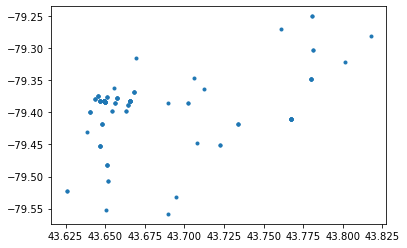

In [37]:
#convert the sushi + alternative restaurants locations into an array and plot data points 
expanded_alternative_restaurants_array = expanded_alternative_restaurants[['Neighborhood Latitude','Neighborhood Longitude']].to_numpy()

X = expanded_alternative_restaurants_array
plt.figure
plt.scatter(X[:, 0], X[:, 1], marker='.')


In [38]:
#Use K-Means to find the center point 
k_means = KMeans(init="k-means++", n_clusters=1, n_init=12)
k_means.fit(X)
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers
#lat = k_means_cluster_centers[:,0]
#lng = k_means_cluster_centers[:,1]

array([[ 43.67641511, -79.3937259 ]])

In [39]:
#map sushi + alternative restaurants 

#setup Toronto Map
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, Venue, neighborhood in zip(expanded_alternative_restaurants ['Venue Latitude'], 
                                         expanded_alternative_restaurants ['Venue Longitude'], expanded_alternative_restaurants ['Venue'],expanded_alternative_restaurants ['Neighborhood']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
for lat, lng in zip(k_means_cluster_centers[:,0],k_means_cluster_centers[:,1]):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

In [43]:
#explore what other Venues are around our Suggested Site 1

option2_site_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=k_means_cluster_centers[:,0],
                                   longitudes=k_means_cluster_centers[:,1]
                                  )
option2_site_venues

Parkwoods


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.679733,-79.4059,Casa Loma,43.677934,-79.409521,Castle
1,Parkwoods,43.679733,-79.4059,Baldwin Steps,43.677707,-79.408209,Historic Site
2,Parkwoods,43.679733,-79.4059,Casa Loma Stables,43.679395,-79.410905,Museum
3,Parkwoods,43.679733,-79.4059,Flor de Sal,43.677757,-79.407176,Modern European Restaurant
4,Parkwoods,43.679733,-79.4059,Big Crow,43.675896,-79.403680,BBQ Joint
5,Parkwoods,43.679733,-79.4059,Toronto Archives,43.676447,-79.407509,History Museum
6,Parkwoods,43.679733,-79.4059,Spadina Museum: Historic House & Gardens,43.678883,-79.408858,History Museum
7,Parkwoods,43.679733,-79.4059,Blueblood Steakhouse,43.678061,-79.409628,Steakhouse
8,Parkwoods,43.679733,-79.4059,Pour House,43.675641,-79.403821,Pub
9,Parkwoods,43.679733,-79.4059,Tim Hortons,43.675800,-79.403532,Coffee Shop


In [49]:
#map option site 1 & 2 
#setup Toronto Map
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

  
folium.CircleMarker(
        [43.67973333, -79.4059],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

folium.CircleMarker(
        [43.67641511, -79.3937259],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
   
map_toronto
